# Working with Placekey (and Tableau)

An exploration of SafeGraph's Placekey for use in Tableau

_Workbook by Sarah Battersby_

[Placekey](http://placekey.io) is a new open initiative from [SafeGraph](http://safegraph.com).  Placekey provides a unique, standard identifier for physical places (a "where") AS WELL AS a "what" component to track the details for known points-of-interest (POIs).  The ["Why Placekey"](https://assets.website-files.com/5f08ccbb93b299154d34ef7f/5f781dacb8dbcb6d2944a8e0_Why%20Placekey%20-%20Technical%20White%20Paper%20V3.pdf) white paper does a great job at documenting the standard and structure of Placekey coordinates, so I won't do that here - and will just focus on the fun parts of how to use Python to interact with Placekey and how to turn the Placekey information into data that you can work with in Tableau!

In this Notebook, I'm going to walk through some of the common tasks that you might want to do in working with Placekey to return data that you can use to augment your Tableau workflows.

My goal here _is not_ to provide the end-to-end example in Tableau Prep or as a script that you call from Tableau, but to simply walk through a variety of the functions that you may want to use in your workflows.

My super collaborator, Paul Rossman, is providing an example of Placekey in Tableau Prep to show off the functionality and a use case there!

Before I go to far, here are some good places for background reading:

### Libraries and links of interest

* [Placekey API documents](https://docs.placekey.io/#intro) - What is the Placekey API? What can you do with it?
* [Places manual](https://readme.safegraph.com/docs/places-manual#section-placekey) - General documentation on the SafeGraph Places dataset, with a section on Placekey
* [Placekey on PyPI](https://pypi.org/project/placekey/0.0.4/)
* [About Uber's H3](https://eng.uber.com/h3/) - Uber's Hexagonal Hierarchical Spatial Index 
* [H3 Python library](https://github.com/uber/h3-py) - H3 Python library GitHub Repo
* [Helpful H3 Jupyter Notebooks](https://github.com/uber/h3-py-notebooks) 

#### Import some libraries!
We'll use a series of Python libraries to work with our data... 

* _placekey_ - the Placekey library, because it's easy to use to faciliate the translation between Placekey codes and H3 geometries
* _h3_ - the Uber H3 python library.  I'm using this to tap into geometries for the "Where" component of Placekey
* _requests_ - to allow us to call out to the Placekey API.  There are numerous libraries that you can use - I like requests, Paul uses  http.client  Use whatever you like and that works for you!
* _shapely_ - I <3 Shapely!  It's my go-to spatial library for all.the.things.  I'm using it here specifically for Point and Polygon geometries

If you're just going to be playing around with this, I'd recommend creating a virtual environment with these libraries...but you do whatever you like to do with your Python 

In [1]:
import h3
import json
import placekey as pk
import requests
from shapely.geometry import Point, Polygon
from shapely.ops import transform

In [2]:
# # I'm also going to use Leaflet to do some mapping in this notebook, so...
# if the widget doesn't work for you (and you have the library installed), try commenting out the next two lines and running this cell again
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install jupyter-leaflet

# irritating namespace problem with ipyleaflet in that I want to use a module named 'Polygon' and that will conflict with shapely's Polygon
# so I'm just importing ALL THE STUFF!
import ipyleaflet as leaflet

#### Make sure you have Placekey developer credentials
You'll need a Placekey API to use the API

If you already have a developer account, you can just log into the [developer portal](https://dev.placekey.io/default/dashboard) and grab your API key, but if you don't...

**Get set up with a Placekey account!**  It's free to set up a Placekey developer account - just [register for an API key](https://dev.placekey.io/default/register) and then sign into the Developer Portal to copy your API key.

If you're lazy and don't plan on sharing your code or putting it up on a repo somewhere that others can get into it, you can be lazy and just hard-code your API key in your script...but otherwise, you should probably do something a bit smarter.  Maybe read up on Python [secrets](https://docs.python.org/3/library/secrets.html) and using [environment variables](https://dev.to/biplov/handling-passwords-and-secret-keys-using-environment-variables-2ei0) for your passwords?


In [3]:
# Lazy coder - don't share files with your actual API publicly
# API_KEY = "YOUR_API_KEY_GOES_HERE"

#### Set up for calling out to the API

The API has a base URL that we'll use for ALL calls to it, so we can go ahead and set that

And we will use the same general 'header' information in any of our calls, so we can set that up in advance too

In [4]:
url = "https://api.placekey.io/v1/placekey"

headers = {
    "apikey": API_KEY,
    "content-type": "application/json"
    } 

#### Explore different ways that you can input location to Placekey

There are a few different ways that you can define a location to retrieve a Placekey, so let's try out some options!

* Latitude & Longitude - maybe you know an exact location... 
* Street Address - maybe you just know an address...
* Street Address w/ POI information - this is great for when you have lots of locations at the same address...for instance a tall building with a bunch of businesses

I've formatted each of these so they can go directly into a request as a query to Placekey....


In [5]:

payloads = {
    # If you just have lat/lng values
    "lat_lng": '''{ 
        "query": {
            "latitude": 47.647174,
            "longitude": -122.338222
        }
    }''',

    # if you have an address
    "address": ''' {
        "query" : {
            "street_address": "1621 N. 34th Street",
            "city": "Seattle",
            "region": "WA",
            "postal_code": "98103",
            "iso_country_code": "US"
        }
    }''',

    # if you have an address and a name (I have two POIs here...each for different named locations at same address)
    "poi_1": '''{
      "query": {
        "query_id": "Studio Evolve",
        "location_name": "Studio Evolve",
        "street_address": "3333 Wallingford Ave N",
        "city": "Seattle",
        "region": "WA",
        "postal_code": "98103",
        "iso_country_code": "US"
      }
    }''',
    
    "poi_2": '''{
      "query": {
        "query_id": "MiiR",
        "location_name": "MiiR",
        "street_address": "3400 Stone Way N",
        "city": "Seattle",
        "region": "WA",
        "postal_code": "98103",
        "iso_country_code": "US"
      }
    }''',
    
    "poi_3": '''{
      "query": {
        "query_id": "Claret",
        "location_name": "Claret Wine Bar",
        "street_address": "3400 Stone Way N",
        "city": "Seattle",
        "region": "WA",
        "postal_code": "98103",
        "iso_country_code": "US"
      }
    }''',
}

#### Great, now let's actually ask Placekey for some information on these locations!

All we have to do is send a formatted request over to Placekey - the request requires the URL, the query location information, and a set of headers (that we created earlier ^^^)

If all works as we expect, we should get a <Response [200]> in return...which tells us that the request successfully returned a result

Placekey uses standard error codes to tell you about the status of your request:

* **200 - OK** - The request was successful
* **400 - Bad Request** - The request is invalid. Read the message or error fields in the response for information on how to correct it.
* **401 - Unauthorized** - Your API key is invalid. Check that you haven't removed it and that you've used the right header: apikey
* **429 - Too Many Requests** - You have exceeded the permitted rate-limit. Check your dashboard to see how many requests have been made recently.
* **50x - Internal Server Error** - An error occurred within our API. If this occurs, you may need to contact us to resolve the issue.


In [6]:
response = requests.post(
    url, 
    payloads["lat_lng"], 
    headers=headers)

For reference, that query was for our data in lat/lng... the input looked like this:

```

         "query": {
             "latitude": 47.647866,
             "longitude": -122.338030
         }

```

Once we have the response, we can check to make sure it's valid, and then dig into the results that we received...


In [7]:
# you can check the status code of the response (see descriptions above)
response.status_code

200


It's easy to pull the results out by looking at the JSON returned in the response

We'll get two parts - the 'query_id' (we didn't give our query an ID) and the placekey (which returns as a what@where) - the WHAT (if identified) is the part before the @ and the WHERE is the part after the @

In [8]:
# you can check the text of the response
response.text

'{"query_id":"0","placekey":"@5x4-4b3-wc5"}'

In [9]:
# you can get the response as a JSON string
response.json()

{'query_id': '0', 'placekey': '@5x4-4b3-wc5'}

In [10]:
# you can even get a ton of detailed information if you really want to dig in...
response.headers

{'Date': 'Wed, 21 Oct 2020 16:55:09 GMT', 'Content-Type': 'application/json', 'Content-Length': '42', 'Connection': 'keep-alive', 'Set-Cookie': '__cfduid=d4a5a4bde59a6ec1560ecc7d6483bdf931603299309; expires=Fri, 20-Nov-20 16:55:09 GMT; path=/; domain=.placekey.io; HttpOnly; SameSite=Lax; Secure', 'X-RateLimit-Limit-second': '100', 'X-RateLimit-Remaining-second': '99', 'X-RateLimit-Limit-minute': '1000', 'X-RateLimit-Remaining-minute': '999', 'Via': 'kong/1.5.0.4-enterprise-edition', 'X-B3-TraceId': 'd0106693f3b54983bd908ff0c09ca6', 'Access-Control-Allow-Origin': '*', 'X-Kong-Upstream-Latency': '11', 'X-Kong-Proxy-Latency': '57', 'CF-Cache-Status': 'DYNAMIC', 'cf-request-id': '05edaf104d0000def1bba09000000001', 'Expect-CT': 'max-age=604800, report-uri="https://report-uri.cloudflare.com/cdn-cgi/beacon/expect-ct"', 'Report-To': '{"endpoints":[{"url":"https:\\/\\/a.nel.cloudflare.com\\/report?lkg-colo=28&lkg-time=1603299310"}],"group":"cf-nel","max_age":604800}', 'NEL': '{"report_to":"cf-n

#### Try it out with other address types!

I set up four examples locations for queries - one with latitude/longitude, one with an address, and two with different POIs at the same address.  You can see how the returns differ...

Notice that with the two queries with POIs I added in a 'query_id' as well - that lets you name the specific query result. 

In [11]:
# Let's just load them all up into an array
responses = []
for payload_name in payloads:
    response = requests.post(
            url, 
            payloads[payload_name], 
            headers=headers)
       
    responses.append(response.json())

responses

[{'query_id': '0', 'placekey': '@5x4-4b3-wc5'},
 {'query_id': '0', 'placekey': '225@5x4-4b3-wc5'},
 {'query_id': 'Studio Evolve', 'placekey': 'zzw-222@5x4-4b3-wkz'},
 {'query_id': 'MiiR', 'placekey': 'zzw-224@5x4-4b3-x89'},
 {'query_id': 'Claret', 'placekey': 'zzw-225@5x4-4b3-x89'}]

### What can I do with this?

It's great to have a Placekey, but how would I get it on the map?

The Placekey WHERE component connects to an Uber H3 hexagonal region.  We can grab the polygon or the point centroid easily and have a location that we can now map

In [12]:
# Split the Placekey so that we have a WHERE and a WHAT part.  I'm going to use some constants to make it easier to remember which part is which...
WHAT = 0
WHERE = 1

# Note that in this first example, I'm just grabbing a single element from responses[] - this is the one for Tableau 
pk_code = responses[1]['placekey'].split('@')
pk_what = pk_code[WHAT]
pk_where = pk_code[WHERE]

In [13]:
# Get the centroid for the H3 polygon
pk_centroid = Point(pk.placekey_to_geo(pk_where))
# Turn it into Well-Known Text (WKT) so that we can easily dump it into a .hyper file later if we want
pk_centroid_wkt = pk_centroid.to_wkt()

pk_centroid_wkt

'POINT (47.6470969240249858 -122.3382293588681335)'

In [14]:
# Get the polygon for the H3 hexagon
# Turn it into WKT so that we can dump it into a .hyper file later if we want
# use the geo_json=True option to return the coordinates in (longitude, latitude) tuples, otherwise they are returned as (latitude, longitude)
pk_poly = pk.placekey_to_polygon(pk_where, geo_json=True)
pk_poly_wkt = pk.placekey_to_wkt(pk_where, geo_json=True)

pk_poly_wkt

'POLYGON ((-122.3380000457549 47.6465019641238, -122.3372893212374 47.64697462807184, -122.3375186315465 47.64756958623566, -122.338458674929 47.64769187756305, -122.3391693941205 47.6472192114175, -122.3389400752557 47.64662425614209, -122.3380000457549 47.6465019641238))'

### Let's turn this into a map!!!

I'm going to use the ipyleaflet library to draw some quick maps so that we can look at the H3 polygons that are returned

We'll start with one polygon from the lat/lng coordinate input

Note that Leaflet wants (latitude, longitude) ordering on the coordinates, so to map them with the leaflet library I'm going to run off a different set of coordinates with the ordering it wants...for use in Tableau, you really want them in the other order, so use the example above with pk.placekey_to_polygon and geo_json=True


In [15]:
# get polygons with coordinate ordering that Leaflet prefers
leaflet_poly = pk.placekey_to_polygon(pk_where)

polygon = leaflet.Polygon(
    locations=list(leaflet_poly.exterior.coords),
    color="orange", 
    fill_color="orange"
)

# center the map using the centroid for the h3 hexagon
m = leaflet.Map(center=(list(pk_centroid.coords)[0]), zoom=19)
m.add_layer(polygon);

display(m)

Map(center=[47.647096924024986, -122.33822935886813], controls=(ZoomControl(options=['position', 'zoom_in_text…

#### in case the map doesn't load on GitHub when you look at the notebook...here it is!
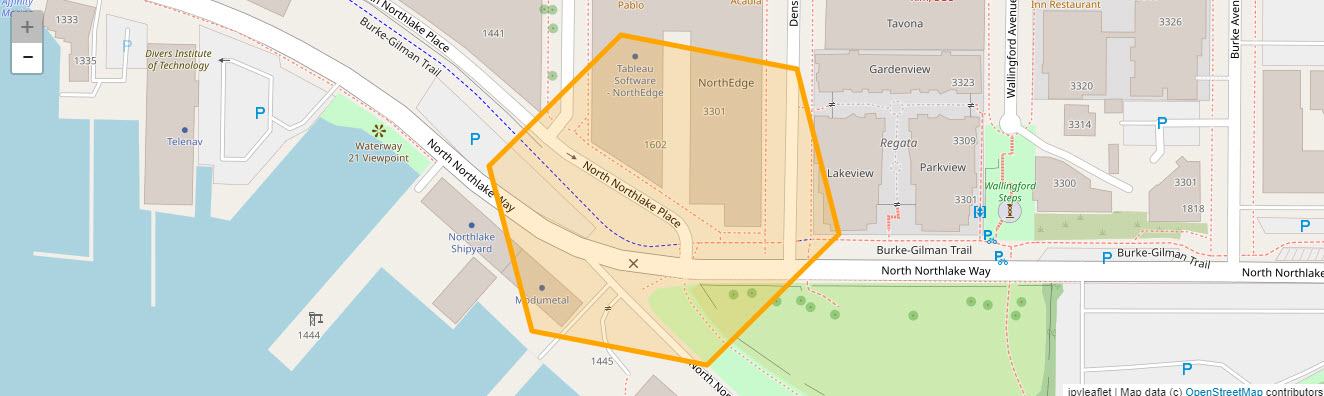

#### Map them all

Or we can just run through all of the data we returned and map them all.

A nice thing about this is that because the polygons that overlap are a bit transparent the opacity will tell you something about how many points fell into each h3 polygon.  

On the map that is generated below you'll see three hexagons, but two of them are darker than the third...because there are two points that fall into each of those two hexagons, and only one that falls into the other.  

In [16]:
map2 = leaflet.Map(center=(list(pk_centroid.coords)[0]), zoom=16)

for response in responses:
    pk_code = response['placekey'].split('@')
    
    # Get the polygon for the H3 hexagon 
    # this is the (latitude, longitude) order that leaflet likes
    leaflet_poly = pk.placekey_to_polygon(pk_code[WHERE])

    # to mix things up, I'm using a color code instead of name...flexible color choice is awesome
    polygon = leaflet.Polygon(
        locations=list(leaflet_poly.exterior.coords),
        color="#245476", 
        fill_color="#6d9fc2",
        fill_opacity=0.5
    )
    
    map2.add_layer(polygon)

display(map2)

Map(center=[47.647096924024986, -122.33822935886813], controls=(ZoomControl(options=['position', 'zoom_in_text…

#### in case the map doesn't load on GitHub when you look at the notebook...here it is!
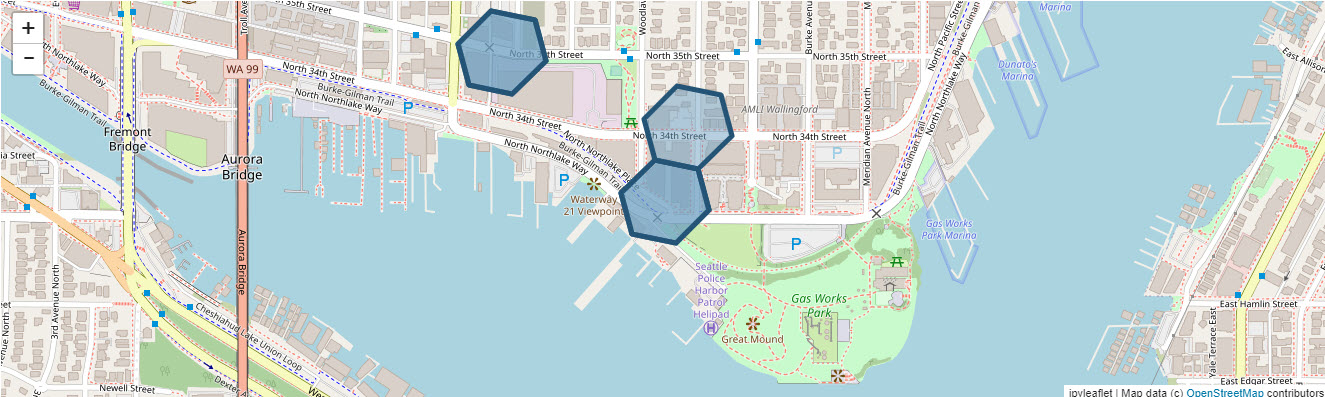

#### This is nice and all, but how about some Tableau?

Yeah, yeah, we can do some stuff with Python and make little maps in a Jupyter notebook, but how does this help me in Tableau?  

1. Paul Rossman has a great Python script as part of this blog that demonstrates a Tableau Prep workflow 
2. It's SO easy to use the Tableau Hyper API to write this data to some .hyper files and just drop it straight into Tableau and go to town... so let's do it!

In [17]:
from tableauhyperapi import HyperProcess, Telemetry, Connection, CreateMode, TableDefinition, Inserter, TableName, SqlType, escape_name
# but this also uses the imports from the top of this notebook, so if you move this into a standalone script, remember to import everything you need

We're going to write a Hyper file with two tables:
* H3 geometry and codes (since multiple locations in our input table can match to the same polygon, there's no point in bloating our table by writing those polygons more than once)
* Original data + Placekey WHAT and WHERE components that we can join to the table with H3 geometries

To do this we'll set up our Hyper file, then magically drop in our data

In [18]:
HYPER_OUTPUT = 'myHyperFile.hyper'

with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as hyper:
    with Connection(hyper.endpoint, HYPER_OUTPUT, CreateMode.CREATE_AND_REPLACE) as connection:
        # create a connection to your schema - named 'Placekey' here
        connection.catalog.create_schema('Placekey')
       
        # create a table to drop the attribute data into ('OriginalData')
        data_table = TableDefinition( TableName('Placekey','OriginalData'), [
            TableDefinition.Column('query_id', SqlType.text()),
            TableDefinition.Column('location_name', SqlType.text()),
            TableDefinition.Column('street_address', SqlType.text()),
            TableDefinition.Column('city', SqlType.text()),
            TableDefinition.Column('region', SqlType.text()),
            TableDefinition.Column('postal_code', SqlType.text()),
            TableDefinition.Column('iso_country_code', SqlType.text()),
            TableDefinition.Column('latitude', SqlType.double()),
            TableDefinition.Column('longitude', SqlType.double()),
            TableDefinition.Column('placekey_what', SqlType.text()),
            TableDefinition.Column('placekey_where', SqlType.text()),
        ])
        
        # create a table to drop the geometry into ('GeomData')
        geom_table = TableDefinition( TableName('Placekey', 'GeomData'), [
            TableDefinition.Column('placekey_where', SqlType.text()),
            TableDefinition.Column('geom_h3', SqlType.geography()),
        ])
    
        # create the table
        connection.catalog.create_table(data_table)
        connection.catalog.create_table(geom_table)
    
        # Do some special steps to create the table with spatial data
        # inserter definition for the geography data
        # See the hyperAPI docs on writing spatial data for more details
        # https://help.tableau.com/current/api/hyper_api/en-us/docs/hyper_api_geodata.html
        geom_inserter_definition = [
            TableDefinition.Column('placekey_where', SqlType.text()),
            TableDefinition.Column('geom_h3_as_text', SqlType.text())
        ]
        
        # map the geom as text to the geom as geometry
        column_mappings = [
            'placekey_where',
            Inserter.ColumnMapping('geom_h3', f'CAST({escape_name("geom_h3_as_text")} AS GEOGRAPHY)')
        ]
    
        # walk through the input info, get results, and then drop it into a row in the .hyper
        # I'm doing this the crazy verbose way so it's clear what's happening, but you can simplify :)
        with Inserter(connection, data_table) as data_inserter:
            unique_pk_where = []
            
            for payload_name in payloads:
                # we'll put everything into an array for each row...
                row = []
                geom_row = []

                # get the response from Placekey for each payload - I'm just re-doing the steps above 
                # so that it's all in one workflow as a demo
                response = requests.post(
                        url, 
                        payloads[payload_name], 
                        headers=headers)           

                # we know all the query details so can grab those quickly
                payload_query = json.loads(payloads[payload_name])['query']

                # and drop them into the array for a single row
                row.append(payload_query.get("query_id"))
                row.append(payload_query.get("location_name"))
                row.append(payload_query.get("street_address"))
                row.append(payload_query.get("city"))
                row.append(payload_query.get("region"))
                row.append(payload_query.get("postal_code"))
                row.append(payload_query.get("iso_country_code"))
                row.append(payload_query.get("latitude"))
                row.append(payload_query.get("longitude"))
                
                # now we just need to tack on the placekey results results as well           
                pk_code = response.json()['placekey'].split('@')

                # earlier in the notebook I set 'WHAT' = 0 and 'WHERE' = 1
                # so if you're copy pasting this, make sure you set those!
                pk_what = pk_code[WHAT]
                pk_where = pk_code[WHERE]

                # drop them into the array
                row.append(pk_what)
                row.append(pk_where)
            
                # and insert it all into a row
                data_inserter.add_row(
                    row
                )
                
                # while we're here update our list of unique h3 codes in the results
                if pk_where not in unique_pk_where:
                    unique_pk_where.append(pk_where)
                
            # boom.  Executed.
            data_inserter.execute()  
        
        # write the geom table using our set of unique h3 codes
        with Inserter(connection, geom_table, column_mappings, inserter_definition=geom_inserter_definition) as geom_inserter:
            
            for where_code in unique_pk_where:
                # and now we want to drop the geometry into the geom table
                pk_poly_wkt = pk.placekey_to_polygon(pk_where, geo_json=True).to_wkt()

                geom_inserter.add_row(
                    [where_code, pk_poly_wkt]
                )

            # boom.  Executed.
            geom_inserter.execute()  

        print("The data was added to the table.")
    print("The connection to the Hyper extract file is closed.")
print("The HyperProcess has shut down.")

The data was added to the table.
The connection to the Hyper extract file is closed.
The HyperProcess has shut down.


And that gives you a nice .hyper file with two tables - one with your original data and one with the geometries for the h3 polygons.  You can drop the .hyper straight into Tableau and explore.

Of course, it would probably be more interesting with a real dataset and attribute set instead of five locations that I selected to be close together and that I know would fall into overlapping h3 polygons.  